In [1]:
import os
os.environ["MUJOCO_GL"] = "egl"
import gym
from gym import spaces
import mujoco
import numba
import imageio
import importlib  
import matplotlib.pyplot as plt 
import matplotlib.animation as anim
import matplotlib.cm as cm
import Rebound_WTA_lib as WTA 
import networkx as nx
from pyvis.network import Network
import os, numpy as np, networkx as nx
import json, time, tempfile, shutil, numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from pyvis.network import Network
import networkx as nx
import numpy as np


import webcolors
import utility_v2 as util
importlib.reload(WTA)
importlib.reload(util)

<module 'utility_v2' from '/home/tony/Documents/python/WTA_snake_paper/utility_v2.py'>

In [23]:
cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)  # Initialize with default values.

# Set camera type to free.
cam.type = mujoco.mjtCamera.mjCAMERA_FREE

# Set the desired parameters.
cam.lookat[:] = np.array([0.5, 0.5, 0.0])
cam.azimuth = 90.0
cam.elevation = -20.0
cam.distance = 4.0


@numba.njit
def controller_spring_single_ring(neuron_states,joint_positions):
    controller_upper_pos=1
    controller_lower_pos=-1
    
    upper_stiffness=WTA.Relu(neuron_states[0:4,0]+1.2)+WTA.Relu(neuron_states[8:12,0]+1)*0
    lower_stiffness=WTA.Relu(neuron_states[4:8,0]+1.2)+WTA.Relu(neuron_states[12:16,0]+1)*0

    torque = (-(joint_positions - controller_upper_pos) * upper_stiffness - (joint_positions - controller_lower_pos) * lower_stiffness)*np.array([1,0.9,0.8,0.7])

    return torque

# @numba.njit
# def controller(neuron_states,joint_positions):
#     controller_upper_pos=(WTA.Relu(neuron_states[10:14,4]+2)-WTA.Relu(neuron_states[10:14,4]+1.75))*1.5*4*np.array([1,1,1,1])+((WTA.Relu(neuron_states[18,6]+2.75)-WTA.Relu(neuron_states[18,6]+2.5))*2)
#     controller_lower_pos=-(WTA.Relu(neuron_states[14:18,4]+2)-WTA.Relu(neuron_states[14:18,4]+1.75))*1.5*4*np.array([1,1,1,1])-((WTA.Relu(neuron_states[20,6]+2.75)-WTA.Relu(neuron_states[20,6]+2.5))*2)
    
#     upper_stiffness=1#+WTA.Relu(neuron_states[4:8,6]+1.2)
#     lower_stiffness=1#+WTA.Relu(neuron_states[0:4,6]+1.2)

#     torque = (WTA.Relu(-joint_positions + controller_upper_pos) * upper_stiffness - WTA.Relu(joint_positions - controller_lower_pos) * lower_stiffness)*10*np.array([1,1,1,1]) #np.array([1,0.7,0.6,0.5])

#     return torque

@numba.njit
def sigmoid(z):
    # numerically stable for large |z|
    return np.where(z >= 0.0, 1.0 / (1.0 + np.exp(-z)), np.exp(z) / (1.0 + np.exp(z)))

@numba.njit
def sigmoid_gate_for_relu_diff(x, a, b, alpha=1.0):
    """
    Approximate ReLU(x+a) - ReLU(x+b) with a single sigmoid gate:
        Δ * σ(k * (x + (a+b)/2)), where Δ = a - b and k = alpha * 4 / Δ
    Assumes a > b. Works with scalars or arrays.
    """
    delta = a - b
    c = 0.5 * (a + b)                 # midpoint of the original ramp region
    k = alpha * (4.0 / delta)         # matches slope at center when alpha=1
    return delta * sigmoid(k * (x + c))


@numba.njit
def controller(neuron_states,joint_positions):
    a1, b1 = 2.0, 1.75
    a2, b2 = 2.75, 2.50
    alpha=1.0
    upper_stiffness = 1.0
    lower_stiffness = 1.0


    x_u = neuron_states[10:14, 4]
    x_l = neuron_states[14:18, 4]

    term_u = sigmoid_gate_for_relu_diff(x_u, a1, b1, alpha) * (1.5 * 4.0)
    term_l = sigmoid_gate_for_relu_diff(x_l, a1, b1, alpha) * (1.5 * 4.0)

    bias_u = sigmoid_gate_for_relu_diff(neuron_states[18, 6], a2, b2, alpha) * 2.0
    bias_l = sigmoid_gate_for_relu_diff(neuron_states[20, 6], a2, b2, alpha) * 2.0

    controller_upper_pos = term_u + bias_u
    controller_lower_pos = -term_l - bias_l

    torque = ((-joint_positions + controller_upper_pos) * upper_stiffness - (joint_positions - controller_lower_pos) * lower_stiffness)*10*np.array([1,1,1,1]) #np.array([1,0.7,0.6,0.5])

    return torque


class SnakeEnv(gym.Env):
    metadata = {'render.modes': ['headless']}

    def __init__(self, xml_path="snake_model_obstacle.xml", render_width=1500, render_height=1500, dt=0.0005/2):
        super(SnakeEnv, self).__init__()
        if not os.path.exists(xml_path):
            raise FileNotFoundError(f"XML file not found: {xml_path}")
        
        # Load the MuJoCo model and simulation data.
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data = mujoco.MjData(self.model)

        self.model.opt.gravity[:] = np.array([0, 0, -9.81])
        
        self.render_width = render_width
        self.render_height = render_height
        self.snapshot_time=0.0
        self.frames = []

        self.model.opt.timestep = dt
        # set colors, avoid using similar colors for different synapses, avoid using light colors
        self.colors = [webcolors.name_to_hex("red"),
                       webcolors.name_to_hex("blue"),
                       webcolors.name_to_hex("green"),
                       webcolors.name_to_hex("orange"),
                       webcolors.name_to_hex("purple"),
                       webcolors.name_to_hex("brown"),
                       webcolors.name_to_hex("pink"),
                       webcolors.name_to_hex("gray"),
                       webcolors.name_to_hex("black"),
                       webcolors.name_to_hex("yellow")]
        self.net=None
        self.per_centre=None
        self.node_pos_by_name= {}
        self.edge_colours_by_id=[]
                          

        self.color_index = 0
        
        # IMPORTANT: Renderer expects (model, height, width) so swap the order.
        self.renderer = mujoco.Renderer(self.model, self.render_height, self.render_width)
        
        # Define action space: 5 continuous torque values.
        self.action_space = spaces.Box(low=-5, high=5.0, shape=(4,), dtype=np.float32)
        
        # Define observation space as concatenated positions and velocities.
        obs = self._get_obs()
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=obs.shape, dtype=np.float32)
        
        self.touch_id   = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_SENSOR, "head_touch")  # sensor index
        self.touch_adr        = self.model.sensor_adr[self.touch_id]      # first index in sensordata
        self.touch_dim        = self.model.sensor_dim[self.touch_id]      # number of scalars (touch → 1)
        self.force_output = []
        self.filtered_force_output = []
        self.head_xyz = []

        

    def initialize_neural_controller(self,
                                      num_neurons=38,
                                      neuron_types=None,
                                      num_syn_types=4,
                                      neuron_names=None,
                                      syn_matrixs=None,
                                      shifts=None,
                                      syn_taus=None,
                                      syn_alphas=None):
         # Neural controller
        self.num_neuron=num_neurons
        if neuron_names is None:
            self.neuron_names = dict()
        else:
            # assert neuron_names type is dict
            assert isinstance(neuron_names, dict), "neuron_names should be a dictionary"
            self.neuron_names = neuron_names
        self.num_neuron_states=3
        
        self.neuron_types=np.zeros((3,self.num_neuron))


        if np.array([neuron_types,syn_matrixs,shifts,syn_taus,syn_alphas]).any() is None:

            print("Using default neural controller, because no neuron_types,syn_matrixs,shifts,syn_taus or syn_alphas is provided")
           
            self.neuron_types[0,:]=1.0
            self.inhibition_matrix=np.zeros((self.num_neuron, self.num_neuron))
            self.excitation_matrix=np.zeros((self.num_neuron, self.num_neuron))
            self.num_syn_types=4
            self.syn_matrixs=np.zeros((self.num_syn_types,self.num_neuron, self.num_neuron))
            self.shifts=np.ones((self.num_syn_types,self.num_neuron))
            self.syn_taus=np.ones((self.num_syn_types,self.num_neuron))
            self.syn_alphas=np.ones((self.num_syn_types,self.num_neuron))

            shifts=np.array([-2.5,-2.5,0,-3.5])
            syn_taus=np.array([0.5,20,0.5,100])
            syn_alphas=np.array([50,50,50,50])

            for i in range(self.num_syn_types):
                self.shifts[i,:]=self.shifts[i,:]*shifts[i]
                self.syn_taus[i,:]=self.syn_taus[i,:]*syn_taus[i]
                self.syn_alphas[i,:]=self.syn_alphas[i,:]*syn_alphas[i]

            _,self.excitation_matrix[:5,:5]=WTA.ring_topology_gen(5,0.75,0.0)
            _,self.excitation_matrix[5:10,5:10]=WTA.ring_topology_revert_gen(5,0.75,0.0)

            self.neuron_types[0,4]=0
            self.neuron_types[2,4]=1
            # self.shifts[0,4]=self.shifts[0,4]
            # self.syn_taus[0,4]=0.5
            # self.syn_taus[1,4]=5

            self.neuron_types[0,5]=0
            self.neuron_types[2,5]=1
            # self.shifts[0,7]=self.shifts[0,7]
            # self.syn_taus[0,7]=0.5
            # self.syn_taus[1,7]=5


            self.inhibition_matrix[:10,:10],_=WTA.ring_topology_gen(10,0,2.5)

            # self.inhibition_matrix[4,:]=5*self.inhibition_matrix[4,:]#+20*(self.inhibition_matrix[4,:]>0)
            # self.inhibition_matrix[7,:]=5*self.inhibition_matrix[7,:]#+20*(self.inhibition_matrix[7,:]>0)

            # self.inhibition_matrix[18:24,18:24],_=WTA.ring_topology_gen(6,0.0,2.5)
            self.inhibition_matrix[24:28,24:28],_=WTA.ring_topology_gen(4,0.0,2.5)


            # self.excitation_matrix[18,19]=1.0
            # self.excitation_matrix[19,18]=1.0

            # self.excitation_matrix[20,21]=1.0
            # self.excitation_matrix[21,20]=1.0

            # self.excitation_matrix[22,23]=1.0
            # self.excitation_matrix[23,22]=1.0

            self.excitation_matrix[24,25]=1.0
            self.excitation_matrix[25,24]=1.0

            self.excitation_matrix[26,27]=1.0
            self.excitation_matrix[27,26]=1.0


            # self.syn_matrixs[3,:,4]=self.excitation_matrix[:,4]
            # self.syn_matrixs[3,:,5]=self.excitation_matrix[:,5]
            # self.syn_matrixs[3,4,5]=-0.5
            # self.syn_matrixs[3,5,4]=-0.5

            # self.excitation_matrix[:,4]=0
            # self.excitation_matrix[:,5]=0

            
            self.syn_matrixs[0,:,:]=-self.inhibition_matrix
            self.syn_matrixs[1,:,:]=self.excitation_matrix

            for i in range(4):
                self.syn_matrixs[2,i+10,28+i]=1.5
                self.syn_matrixs[2,i+10,32+i]=-3

                
                self.syn_matrixs[2,i+14,28+i]=-3
                self.syn_matrixs[2,i+14,32+i]=1.5

                # self.syn_matrixs[3,(i+1)%4 +14,28+i]=10.0
                # self.syn_matrixs[3,(i+1)%4 +10,32+i]=10.0

                # self.syn_matrixs[2,28+i,24]=-15
                self.syn_matrixs[1,28+i,i]=1
                self.syn_matrixs[1,28+i,i+6]=1

                # self.syn_matrixs[2,32+i,26]=-15
                self.syn_matrixs[1,32+i,i]=1
                self.syn_matrixs[1,32+i,i+6]=1
                
                self.syn_matrixs[0,i+10,i+14]=-2.0
                self.syn_matrixs[0,i+14,i+10]=-2.0
                # self.syn_matrixs[3,i+10,i+14]=0.7
                # self.syn_matrixs[3,i+14,i+10]=0.7
               
            self.syn_matrixs[0,22,10]=0.6
            self.syn_matrixs[0,23,14]=0.6
            self.syn_matrixs[0,22,0]=1
            self.syn_matrixs[0,23,0]=1
            self.syn_matrixs[0,28,22]=1.5
            self.syn_matrixs[0,32,23]=1.5

            self.syn_matrixs[0,36,13]=0.6
            self.syn_matrixs[0,37,17]=0.6
            self.syn_matrixs[0,36,9]=1
            self.syn_matrixs[0,37,9]=1
            self.syn_matrixs[0,31,36]=1.5
            self.syn_matrixs[0,35,37]=1.5
         

            for i in range(3):
                self.syn_matrixs[1,29+i,28+i]=1.5
                self.syn_matrixs[1,33+i,32+i]=1.5

                self.syn_matrixs[1,30-i,31-i]=1.5
                self.syn_matrixs[1,34-i,35-i]=1.5

                # self.syn_matrixs[1,28+i,32+i]=-0.5
                # self.syn_matrixs[1,32+i,28+i]=-0.5
                # self.syn_matrixs[3,i+10,i+14]=0.7
                # self.syn_matrixs[3,i+14,i+10]=0.7
               
            # for i in range(4):
            #     self.syn_matrixs[3,(i+1)%4 +14,28+i]=15.0
            #     self.syn_matrixs[3,(i+1)%4 +10,32+i]=15.0
                
            self.syn_matrixs[3,19,24]=1.0
            self.syn_matrixs[3,18,26]=1.0

            self.syn_matrixs[1,9,19]=2.0

            self.syn_matrixs[1,20,18]=-1.0
            self.syn_matrixs[1,21,19]=1.0

            self.syn_matrixs[1,24,20]=2
            self.syn_matrixs[1,26,21]=2
            
            # self.syn_matrixs[1,4,0:3]=-self.inhibition_matrix[4,0:3]
            # self.syn_matrixs[1,5,7:10]=-self.inhibition_matrix[5,7:10]

            self.neuron_types[0,10:18]=0.0
            self.neuron_types[1,10:18]=1.0

            print(self.syn_matrixs[0,:,:])
            print(self.syn_matrixs[1,:,:])

        else:
            assert len(neuron_types)==self.num_neuron, "neuron_types should have the same number of neurons as the model"
            assert syn_matrixs.shape[0]==num_syn_types==shifts.shape[0]==syn_taus.shape[0]==syn_alphas.shape[0], "syn_matrixs,shifts,syn_taus,syn_alphas should have the same number of synapse types"
            print("Using custom neural controller")
            self.neuron_types[0,:]=neuron_types
            self.syn_matrixs=syn_matrixs
            self.shifts=shifts
            self.syn_taus=syn_taus
            self.syn_alphas=syn_alphas
            self.num_syn_types=len(self.shifts)

        
        
        self.num_state=self.num_neuron_states+self.num_syn_types


        x0=np.random.rand(self.num_neuron,self.num_state)*0.1
        x0[0,0]=0.0
        self.neuron_states=np.copy(x0)
        self.neuron_outputs=[]
        self.torque_outputs=[]
        self.const_input = np.ones(self.num_neuron)*0.0

        #linear controller
        self.k_1=5.0
        self.k_2=5.0

        self.gain_array=np.array([1,0.9,0.9,0.9])*8*10*2*8


    def set_graph(self):
        # assert types are correct
        assert isinstance(self.syn_matrixs, np.ndarray), "syn_matrixs should be a numpy array"
        assert isinstance(self.shifts, np.ndarray), "shifts should be a numpy array"
        assert isinstance(self.syn_taus, np.ndarray), "syn_taus should be a numpy array"
        assert isinstance(self.syn_alphas, np.ndarray), "syn_alphas should be a numpy array"
        assert isinstance(self.neuron_names, dict), "neuron_names should be a dictionary"
        assert isinstance(self.node_pos_by_name, dict), "node_pos_by_name should be a dictionary"
        assert isinstance(self.edge_colours_by_id, list), "edge_colours_by_id should be a list"
        
        self.graph=util.Graph(self.syn_matrixs,self.syn_taus,self.syn_alphas,self.shifts,self.neuron_names,self.node_pos_by_name,None,self.edge_colours_by_id)


    def calculate_graph(self,matrix_find_centre):

        return self.graph.calculate_graph(matrix_find_centre)

  
    def build_dashboard(
            self,
            volt_traces,                # ndarray (N, T)
            video_file,                 # "run_capture.mp4"
            out_dir="animations",
            play_on_load=False,
            fps=30,
            graphs=None):
        
        self.graph.build_dashboard(volt_traces=volt_traces, video_file=video_file, out_dir=out_dir, play_on_load=play_on_load, fps=fps, graphs=graphs)

    def _get_obs(self):
        # Concatenate generalized positions and velocities.
        return np.concatenate([self.data.qpos.ravel(), self.data.qvel.ravel()])

    def step(self, action,fps):
        # Clip and apply action torques.
        self.snapshot_time = self.data.time

        t_action = self.data.time+1
        # Advance the simulation.
        with mujoco.Renderer(self.model) as self.renderer:
            while self.data.time < t_action:
                            
                self.data.ctrl[:] =np.clip(action)

                mujoco.mj_step(self.model, self.data)
                
                if self.data.time > self.snapshot_time:
                    self.snapshot_time = self.data.time + 1/fps
                    self.renderer.update_scene(self.data,cam)
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
    
        obs = self._get_obs()
        # Reward: forward progress along the x-axis.
        reward = self.data.qpos[0]
        # Terminate if the snake's base (z at index 2) falls too low.
        done = bool(self.data.qpos[2] < -2.00)
        return obs, reward, done, {}
    

    def sim(self,time,fps,u):
        # Clip and apply action torques.
        self.snapshot_time = self.data.time
        filtered_sensor=0
        t_action = self.data.time+time
        # Advance the simulation.
        with mujoco.Renderer(self.model) as self.renderer:
            while self.data.time < t_action:
             
                self.data.ctrl[:] =np.clip(controller(self.neuron_states,self.data.qpos.ravel()[4:8])-self.data.qpos.ravel()[4:8]*self.k_1-self.data.qvel.ravel()[4:8]*self.k_2, self.action_space.low, self.action_space.high)
                mujoco.mj_step(self.model, self.data)
                
                filtered_sensor = filtered_sensor - (filtered_sensor - self.data.sensor('head_contact').data.copy()) * self.model.opt.timestep * 0.8

                self.const_input,modulation,period,modulation_motor=u(self.data.time,self.neuron_states,self.data.qpos.ravel()[4:8],self.data.qvel.ravel()[4:8],filtered_sensor)



                dx=WTA.ss_Luka_topology_multi_syn_multi_neuron(self.num_neuron, self.neuron_states, self.const_input, self.syn_matrixs, self.shifts, self.syn_taus, self.syn_alphas, self.neuron_types, 0.1, -1.0,modulation,time=period,modulation_motor=modulation_motor)
                
                
                self.neuron_states=self.neuron_states+dx*self.model.opt.timestep*30

                

                

                if self.data.time > self.snapshot_time:
                    self.snapshot_time = self.data.time + 1/fps
                    self.renderer.update_scene(self.data,cam)
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
                    self.neuron_outputs.append(np.copy(self.neuron_states))
                    self.torque_outputs.append(np.copy(self.data.ctrl))
                    self.force_output.append(self.data.sensor('head_contact').data.copy())
                    self.filtered_force_output.append(filtered_sensor.copy())
                    self.head_xyz.append(self.data.sensor('head_xyz').data.copy())


    def reset(self):
        # Reset simulation state and propagate kinematics.
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.snapshot_time=0.0
        x0=(np.random.rand(self.num_neuron,self.num_state)*2-1)*2
        self.neuron_states=np.copy(x0)
        self.neuron_outputs=[]
        self.torque_outputs=[]
        
        return self._get_obs()

    def record_video(self, filename="simulation.mp4", fps=30, camera_id=0,out_dir=None,u=None):
        # check if the directory exists, if not create it
        if out_dir is not None:
            os.makedirs(out_dir, exist_ok=True)
            filename = os.path.join(out_dir, filename)
        else:
            os.makedirs("videos", exist_ok=True)
            filename = os.path.join("videos", filename)
            
        self.reset()

        if u is None:
            u = lambda t, neuron_states, joint_positions, joint_velocities: np.zeros(self.num_neuron)

        self.sim(90, fps,u)
        # Specify the 'ffmpeg' format explicitly.
        imageio.mimwrite(filename, self.frames, fps=fps, quality=10, format="ffmpeg")
        print(f"Video saved to {filename}")

    def close(self):
        # Free the renderer.
        self.renderer = None



In [24]:
env = SnakeEnv(xml_path="snake_model.xml")
env.initialize_neural_controller()
env.edge_colours_by_id.append([set(),"purple"])
env.edge_colours_by_id.append([set(),"grey"])
env.edge_colours_by_id.append([set(),"grey"])
for i in range(4):
    env.neuron_names[f"{i+10}"]=f"Left Joint{i+1}"
    env.node_pos_by_name[f"Left Joint{i+1}"]=[0,0+i*200]
    env.neuron_names[f"{i+14}"]=f"Right Joint{i+1}"
    env.node_pos_by_name[f"Right Joint{i+1}"]=[1000,0+i*200]
    env.neuron_names[f"{i}"]=f"Foward {i+1}"
    env.neuron_names[f"{i+6}"]=f"Backward {i+1}"
    env.edge_colours_by_id[0][0].add(i+10)
    env.edge_colours_by_id[0][0].add(i+14)
    env.edge_colours_by_id[1][0].add(i+10)
    env.edge_colours_by_id[1][0].add(i+28)
    env.edge_colours_by_id[1][0].add(i+32)
    env.edge_colours_by_id[2][0].add(i+14)
    env.edge_colours_by_id[2][0].add(i+28)
    env.edge_colours_by_id[2][0].add(i+32)
    


env.neuron_names[f"{18}"]=f"Turn Right 1"
env.neuron_names[f"{19}"]=f"Turn Right 2"
env.neuron_names[f"{20}"]=f"Turn Left 1"
env.neuron_names[f"{21}"]=f"Turn Left 2"
env.neuron_names[f"{22}"]=f"Forward 1"
env.neuron_names[f"{23}"]=f"Forward 2"

env.neuron_names[f"{24}"]=f"Left first 1"
env.neuron_names[f"{25}"]=f"Left first 2"

env.neuron_names[f"{26}"]=f"Right first 1"
env.neuron_names[f"{27}"]=f"Right first 2"


def u(t,neuron_states,joint_positions,joint_velocities,sensor):
    const_input=np.zeros(env.num_neuron)
    modulation=np.zeros(env.num_neuron)
    modulation[4:6]=0.2
    # external inputs
    const_input[:]=-0.5
    # const_input[4:6]=-0.5
    # const_input[0:10]+=0.3
    # const_input[4]=-0.
    # const_input[5]=-0
    const_input[10:18]=np.ones(8)*0
    const_input[28:36]=-2.0
    const_input[22:24]=-2.0
    const_input[36:38]=-2.0
    const_input[18:20]=-2.0
    const_input[0:10]+=1
    period=5
    modulation_motor=0*np.ones((env.num_neuron))

    if 1<t <2:
        const_input[1]=3
        # const_input[10:14]=10.0
       
    #     period=1.5
    if 45<t<47:
        const_input[14:18]+=2
        
        
    return const_input, modulation,period,modulation_motor


env.set_graph()

graphs_html=env.calculate_graph([True,False,False,False])
print(graphs_html)

Using default neural controller, because no neuron_types,syn_matrixs,shifts,syn_taus or syn_alphas is provided
[[-0.  -2.5 -2.5 ... -0.  -0.  -0. ]
 [-2.5 -0.  -2.5 ... -0.  -0.  -0. ]
 [-2.5 -2.5 -0.  ... -0.  -0.  -0. ]
 ...
 [-0.  -0.  -0.  ... -0.  -0.   1.5]
 [-0.  -0.  -0.  ... -0.  -0.  -0. ]
 [-0.  -0.  -0.  ... -0.  -0.  -0. ]]
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.75 0.   0.   ... 0.   0.   0.  ]
 [0.   0.75 0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
{'full': PosixPath('four_relations_network.html'), 'community:38': PosixPath('community_38.html'), 'community:39': PosixPath('community_39.html'), 'community:40': PosixPath('community_40.html'), 'community:41': PosixPath('community_41.html'), 'community:42': PosixPath('community_42.html'), 'community:43': PosixPath('community_43.html'), 'residual': PosixPath('residual_edges.html')}


In [25]:
folder="animations_pattern"
env.record_video(filename="snake_simulation.mp4", fps=30,out_dir=folder,u=u)
env.close()

Video saved to animations_pattern/snake_simulation.mp4


In [26]:
volt_traces = np.array(env.neuron_outputs)[:,:,0].T

In [27]:
env.build_dashboard(volt_traces,video_file="snake_simulation.mp4", out_dir=folder,fps=30)

✔ Dashboard ready → animations_pattern/all_animations.html


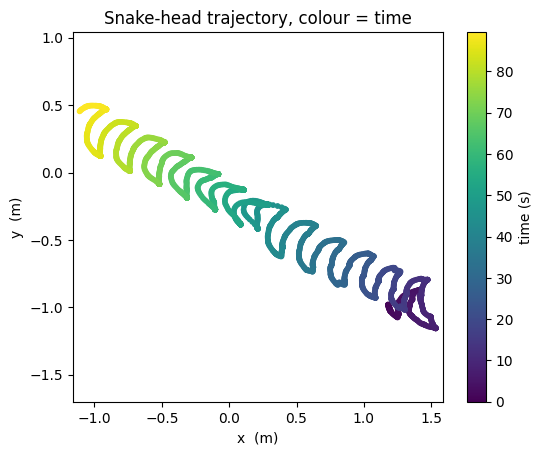

In [28]:
trajectory = np.array(env.head_xyz)[:,:2]
t = np.arange(len(trajectory))          # 0 … T-1
x, y = trajectory.T

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=t*1/30, cmap="viridis", s=10)   # one dot per step
dim  = max(x.ptp(), y.ptp())+0.1          # largest span
xmid = (x.max() + x.min())/2
ymid = (y.max() + y.min())/2
ax.set_xlim(xmid - dim/2, xmid + dim/2)
ax.set_ylim(ymid - dim/2, ymid + dim/2)
cbar = fig.colorbar(sc, label="time (s)", ax=ax)                # legend on the right

# from matplotlib.ticker import FuncFormatter
# # multiply every tick value (which is a step index) by dt
# cbar.ax.yaxis.set_major_formatter(
#         FuncFormatter(lambda v, pos: f"{v*1/30:.2f}"))
# cbar.update_ticks()

ax.set_aspect("equal")
ax.set_xlabel("x  (m)")
ax.set_ylabel("y  (m)")
ax.set_title("Snake-head trajectory, colour = time")
fig.savefig(folder+"/snake_head_trajectory.png")
plt.show()

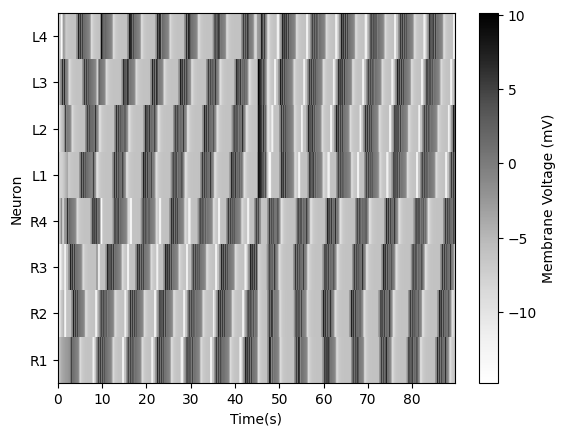

In [30]:
# plt.plot(np.array(env.neuron_outputs)[0:,10,0])
# plt.plot(np.array(env.neuron_outputs)[0:,14,0])
data= np.flip(np.array(env.neuron_outputs)[0:,10:18,0],1)

neuron_names = ['R1','R2','R3','R4','L1','L2','L3','L4']
# Use imshow to create a raster plot, transposing so neurons appear on the y-axis.
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='Greys',extent=[0, data.shape[0] * 1/30, 0, data.shape[1]])
plt.xlabel('Time(s)')
plt.ylabel('Neuron')
plt.colorbar(label='Membrane Voltage (mV)')
plt.yticks(ticks=np.arange(0.5, data.shape[1], 1),labels=neuron_names)
plt.savefig(folder+'/raster_HCO.png')

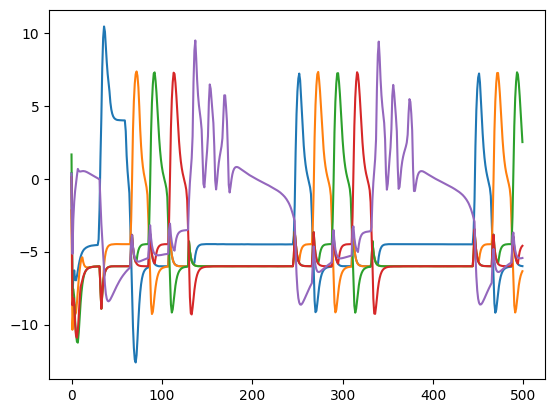

In [157]:
plt.plot(np.array(env.neuron_outputs)[0:500,0:5,0])

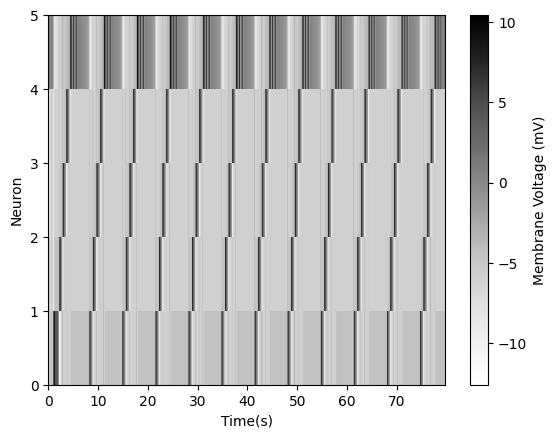

In [158]:
data= np.flip(np.array(env.neuron_outputs)[0:,0:5,0],1)
# Use imshow to create a raster plot, transposing so neurons appear on the y-axis.
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='Greys',extent=[0, data.shape[0] * 1/30, 0, data.shape[1]])
plt.xlabel('Time(s)')
plt.ylabel('Neuron')
plt.colorbar(label='Membrane Voltage (mV)')

plt.savefig(folder+'/raster_forward_ring.png')

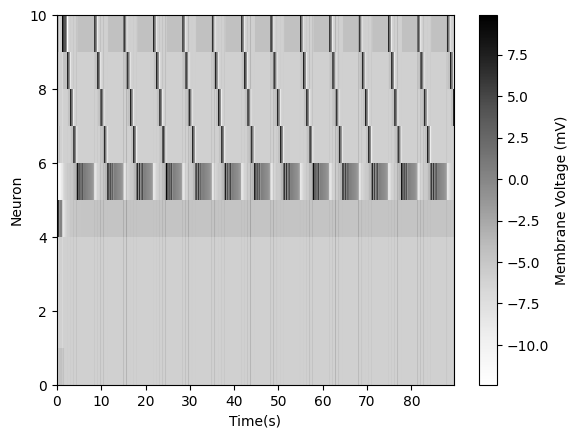

In [638]:
data= np.flip(np.array(env.neuron_outputs)[0:,0:10,0],1)
# Use imshow to create a raster plot, transposing so neurons appear on the y-axis.
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='Greys',extent=[0, data.shape[0] * 1/30, 0, data.shape[1]])
plt.xlabel('Time(s)')
plt.ylabel('Neuron')
plt.colorbar(label='Membrane Voltage (mV)')

# plt.savefig(folder+'/raster_forward_ring.png')